In [85]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torch.distributions import Categorical


#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5
maintenance_cost = 500


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state
tm = [a0_tm,a1_tm]
#r_func = {0:2000,1:1500,2:1000,3:500,4:-maintenance_cost,5:-maintenance_cost,6:-maintenance_cost,7:-maintenance_cost,8:-3000,9:-2000}
r_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

class Machine_env():
    '''
    Description:
    Code creates an environment for the policy to interact with the simulated machine.

    States:
    The simulated machine has 10 states
    [0,1,2,3] are working states that degrades as the state number increases.
    [4,5,6,7] are maintenance states that are transited from [0,1,2,3] respectively if the action deems it need transition
    [8,9] are failure state, where 8 is sudden failure state that can occur from [0,1,2,3] while 9 is a degraded failure from 3

    Actions:
    Type: Discrete(2)
    Num
    0: No maintenance
    1: Maintenance

    Rewards:
    reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

    Observations:
    Produced using MachineSensor class that uses gmm from pickle file

    Episode:
    Since it is continous Markov model, we shall set 1 episode is 20 steps


    Pseudo code

    initialise class
    Loop 20 times: #1 episode
        sensor()
        action()
        step()

    final otp: Class that contains rewards,actions, observations --> will be used to improve policy (ie. optimise theta)
        
''' 

    def __init__(self,machine):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}
        self.observation_space = 4
        self.transition  = [a0_tm,a1_tm]
        self.simulator = machine #simulator to generate sensor readings
        self.done = False
        self.steps = 0
    
    def sensor(self): # generate observation at state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        self.simulator.curr_state = self.state #update GMM state
        
        while(self.state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.transition[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based on prob
            self.state = nxt_state #update state
            self.simulator.curr_state = self.state #update GMM state
            reward+=self.reward_func[nxt_state]
            
        
        self.steps += 1
        
#         if(self.steps == 50):#condition for end of episode
#             self.done = True
        if self.state in [8,9] or self.steps >= 100:
            self.done = True

        return reward
    
    def reset(self):
        self.state = 0
        self.simulator.curr_state = self.state
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        
def padding(x):
    x = torch.FloatTensor(x)
    length_remain = 100-x.shape[0]
    
    if length_remain > 0:
        zero = torch.zeros(length_remain,4)
        x = torch.cat((x,zero),0)
    return x.tolist()

def padding_reward(x):
    pad = [0 for _ in range(100-len(x))]
    x.extend(pad)
    return x

In [86]:
def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(padding(state)))
    return torch.stack(state_vals).squeeze()

def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    
    #store updates
    policy_loss = []
    
    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)
    
    #Backpropagation
    optimizer.zero_grad()
    (sum(policy_loss)/len(policy_loss)).backward()
    optimizer.step()
    
    return sum(policy_loss)



Additional Improvement:
- Recurrent implementation --> action taken by referencing 10 frames behind
- Model does not learn about the maintenance readings = [-1,-1,-1,-1] default action for these states are no action, cost of maintenance is cumulative depending on how long it stays in the maintenance state
- Add batch size which will determine the update frequency of the policy during simulation
- longer episodic update of policy but more of batch update
- Every batch update the input internal states to the next batch is updated


# CNN 

In [96]:

class policy_estimator_cnn(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator_cnn, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1,padding='same')
        self.conv2 = torch.nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, stride=1,padding='same')
        self.layer1 = nn.Linear(4000,128)
        self.layer2 = nn.Linear(128,256)
        self.layer3 = nn.Linear(256,len(env.action_space))
        self.outputlayer = nn.Softmax(dim=-1)
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
        x = x.unsqueeze(1)
        #print(x.shape)
        
        y = self.conv1(x)
        y=F.relu(y)
        #print("1st layer",y.shape)
        y = self.conv2(y)
        y=F.relu(y)
        y=torch.flatten(y)
        #print("2nd layer",y.shape)
        
        
        y = self.layer1(y)
        y= F.relu(y)
        #print("3rd layer",y.shape)
        
        y = self.layer2(y)
        y= F.relu(y)
        #print("4th layer",y.shape)
        
        y = self.layer3(y)
        output = self.outputlayer(y)
        #print(F.softmax(output,dim = -1))


        return F.softmax(output,dim = -1)

class StateValueNetwork_cnn(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork_cnn, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3, stride=1,padding='same')
        self.conv2 = torch.nn.Conv1d(in_channels=20, out_channels=20, kernel_size=3, stride=1,padding='same')
        self.layer1 = nn.Linear(8000,128)
        self.layer2 = nn.Linear(128,256)
        self.layer3 = nn.Linear(256,1)
        
        
    def forward(self, x):
        #input layer
        x = torch.FloatTensor(x)
        x = x.unsqueeze(1)
        
        #print(x.shape)
        y = self.conv1(x)
        y=F.relu(y)
        #print("1st layer",y.shape)
        y = self.conv2(y)
        y=F.relu(y)
        y=torch.flatten(y)
        #print("2nd layer",y.shape)
        
        
        y = self.layer1(y)
        y= F.relu(y)
        #print("3rd layer",y.shape)
        
        y = self.layer2(y)
        y= F.relu(y)
        #print("4th layer",y.shape)
        
        state_value = self.layer3(y)
        
        return state_value

# REINFORCE BASELINE WITH CNN

In [97]:
def reinforce_baseline_cnn(machine,baseline_net,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_obs=[]
    batch_actions = []
    ave_reward_store = []
    batch_counter = 1
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.01)
    
    action_space = machine.action_space
    ep=0
    while ep < num_episodes:
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while machine.done == False:
            obs = machine.sensor().tolist() #get observation
            
            action_probs = policy_estimator(padding([obs])).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            #print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
            
            if machine.done == True:
                norm_rewards = normalized_discount_reward(rewards, gamma)
                batch_rewards.extend(norm_rewards)
                batch_obs.extend(observation)
                batch_actions.extend(actions)
                batch_counter+=1
                total_rewards.append(sum(rewards))
                
                if batch_counter == batch_size:
                    discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
                    #update policy
                    obs_tensor = torch.FloatTensor(batch_obs)
                    action_tensor = torch.LongTensor(batch_actions)
                    reward_tensor = torch.from_numpy(np.array(batch_rewards).copy()) #resolve stride problem
                    
                    #calculate state values 
                    state_value_tensor = stack_state_value(np.array(obs_tensor),baseline_net)

                    #train state value network
                    train_value(reward_tensor,state_value_tensor,state_val_optimizer)

                    #print(f"checking {reward_tensor}, {state_value_tensor}")
                    #calculate delta or advantage 
                    try:
                        deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
                        deltas = torch.tensor(deltas)
                    except:
                        print("Invalid episode")
                        continue


                    #update policy
                    logprob = torch.log(policy_estimator(obs_tensor))
                    selected_logprobs = logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = train_policy(deltas, selected_logprobs, optimizer)
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_obs = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-10:])
                ave_reward_store.append(avg_rewards)
                # Print running average
                print("\rEp: {} Average of last {}: {:.2f}".format(ep+1,batch_size,avg_rewards), end="")
                ep+=1

        
    
    return (ave_reward_store,total_rewards,state_seq)

In [98]:
mach2 = Machine()
mach2.curr_state = 0
machine2 = Machine_env(mach2)
#print(machine1.reward_func)
baseline = StateValueNetwork_cnn(machine2.observation_space)
pol = policy_estimator_cnn(machine2)

#Parameters
episodes = 1000
gamma = 0.95
lr= 0.001
batch_size=1


results = reinforce_baseline_cnn(machine2,baseline,pol,episodes,batch_size,gamma,lr)

Ep: 1000 Average of last 1: 18240.00

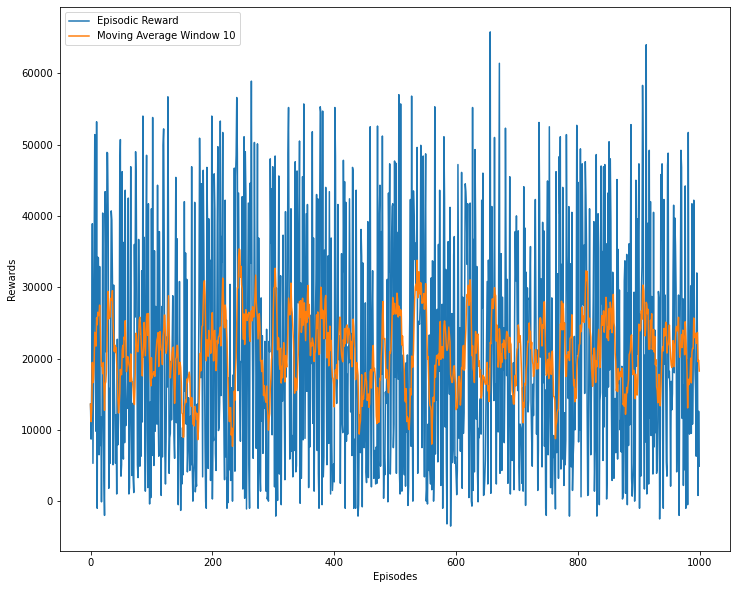

In [100]:
ave_rewards = results[0]
rewards = results[1]
episode = [i for i in range(len(ave_rewards))]
fig = plt.figure(figsize=(12,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,ave_rewards,label = f'Moving Average Window 10')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

In [17]:
x = [[j for j in range(4)] for _ in range(30)]
x = padding(x)
x = np.array(x)
x.shape

(100, 4)